# Training U-Net with logging Example Notebook

This notebook demonstrates how to train `virtual_stain_flow.models` module,
demoing with trainer and logging. 

## Dependencies

In [1]:
import re
import json
import pathlib
from typing import List, Tuple


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure
from mlflow.tracking import MlflowClient

from virtual_stain_flow.trainers.logging_trainer import SingleGeneratorTrainer
from virtual_stain_flow.vsf_logging.MlflowLogger import MlflowLogger
from virtual_stain_flow.vsf_logging.callbacks.PlotCallback import PlotPredictionCallback
from virtual_stain_flow.models.unet import UNet

## Additional utils

Dataset processing and subsetting utils

In [2]:
# Matches filenames like:
# r01c01f01p01-ch1sk1fk1fl1.tiff
FIELD_RE = re.compile(
    r"(r\d{2}c\d{2}f\d{2}p01)-ch(\d+)sk1fk1fl1\.tiff$"
)

def _collect_field_prefixes(
    plate_dir: pathlib.Path,
    max_fields: int = 16,
) -> List[str]:
    """
    Scan a JUMP CPJUMP1 plate directory and collect distinct field prefixes.
    Expects image filename like:
        r01c01f01p01-ch1sk1fk1fl1.tiff
    """
    prefixes: List[str] = []
    for path in sorted(plate_dir.glob("*.tiff")):
        m = FIELD_RE.match(path.name)
        if not m:
            continue
        prefix = m.group(1)  # e.g. "r01c01f01p01"
        if prefix not in prefixes:
            prefixes.append(prefix)
            if len(prefixes) >= max_fields:
                break
    return prefixes


def _load_single_channel(
    plate_dir: pathlib.Path,
    field_prefix: str,
    channel: int,
    normalize: bool = True,
) -> np.ndarray:
    """
    Load a single channel image for a given field prefix and channel index.

    :param plate_dir: Directory containing TIFF files for one JUMP plate
    :param field_prefix: Prefix like 'r01c01f01p01'.
    :param channel: Channel index, e.g. 5 for Hoechst, 7 for BF mid-z.
    :param normalize: If True, convert to float32 and divide by dtype max
    :return: Image array of shape (H, W), float32.
    """
    fname = f"{field_prefix}-ch{channel:d}sk1fk1fl1.tiff"
    path = plate_dir / fname
    if not path.exists():
        raise FileNotFoundError(f"Expected file not found: {path}")

    arr = np.array(Image.open(path))  # typically uint16

    if normalize:
        if np.issubdtype(arr.dtype, np.integer):
            info = np.iinfo(arr.dtype)
            arr = arr.astype("float32") / float(info.max)
        else:
            arr = arr.astype("float32")
    else:
        arr = arr.astype("float32")

    return arr  # (H, W), float32


def load_jump_bf_hoechst(
    plate_dir: str | pathlib.Path,
    max_fields: int = 32,
    bf_channel: int = 7,
    dna_channel: int = 5,
    normalize: bool = True,
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Load a small BF->Hoechst subset from a CPJUMP1 plate.
    
    :param plate_dir: Directory containing TIFF files for one JUMP plate
    :param max_fields: Maximum number of fields to load
    :param bf_channel: Channel index for BF mid-z (default 7)
    :param dna_channel: Channel index for Hoechst (default 5)
    :param normalize: If True, convert to float32 and divide by dtype max
    """
    plate_dir = pathlib.Path(plate_dir)

    if not plate_dir.exists() or not plate_dir.is_dir():
        raise FileNotFoundError(
            f"Plate directory {plate_dir} does not exist or is not a directory."
        )

    prefixes = _collect_field_prefixes(plate_dir, max_fields=max_fields)
    if not prefixes:
        raise RuntimeError(f"No valid JUMP image files found in {plate_dir}")

    bf_list: list[np.ndarray] = []
    dna_list: list[np.ndarray] = []
    used_prefixes: list[str] = []

    for prefix in prefixes:
        try:
            bf = _load_single_channel(
                plate_dir, prefix, bf_channel, normalize=normalize
            )
            dna = _load_single_channel(
                plate_dir, prefix, dna_channel, normalize=normalize
            )
        except FileNotFoundError:
            # Skip incomplete fields (missing channels)
            continue

        # Add channel axis: (1, H, W)
        bf_list.append(bf[None, ...])
        dna_list.append(dna[None, ...])
        used_prefixes.append(prefix)

    if not bf_list:
        raise RuntimeError(
            f"No complete BF + DNA pairs found in {plate_dir} "
            f"for bf_channel={bf_channel}, dna_channel={dna_channel}"
        )

    X = np.stack(bf_list, axis=0)   # (N, 1, H, W)
    Y = np.stack(dna_list, axis=0)  # (N, 1, H, W)

    return X, Y, used_prefixes


Dataset object for training

In [3]:
class SimpleDataset(Dataset):
    """
    Simple dataset for demo purposes.
    Loads images from disk, crops the center, and returns as tensors.
    """
    def __init__(self, X: np.ndarray, Y: np.ndarray, crop_size: int = 256):
        self.X = X
        self.Y = Y
        self.crop_size = crop_size
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx, 0, :, :]
        y = self.Y[idx, 0, :, :]

        # Get image dimensions
        height, width = x.shape
        
        # Calculate crop coordinates for center
        left = (width - self.crop_size) // 2
        top = (height - self.crop_size) // 2
        right = left + self.crop_size
        bottom = top + self.crop_size
        
        # Crop center
        x_crop = x[top:bottom,left:right]
        y_crop = y[top:bottom,left:right]

        # Convert to tensor
        x_tensor = torch.from_numpy(x_crop).unsqueeze(0)  # Add channel dimension
        y_tensor = torch.from_numpy(y_crop).unsqueeze(0)  # Add channel dimension

        return x_tensor, y_tensor


## Load subsetted demo data

X (BF): (64, 1, 1080, 1080) float32
Y (DNA): (64, 1, 1080, 1080) float32
First few fields: ['r01c01f01p01', 'r01c01f02p01', 'r01c01f03p01', 'r01c01f04p01', 'r01c01f05p01']


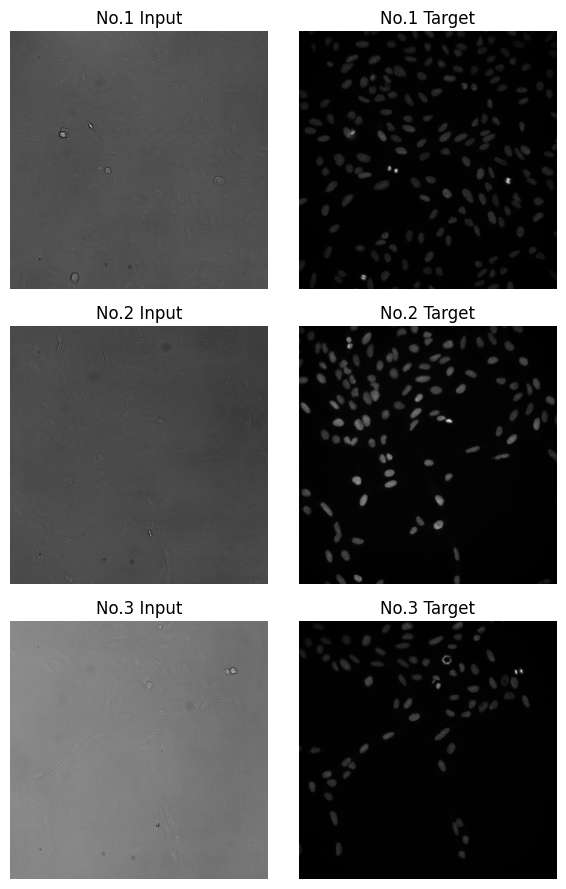

In [ ]:
data_path = pathlib.Path(
    "/mnt/hdd20tb/jump_data/2020_11_04_CPJUMP1/BR00117010__2020-11-08T18_18_00-Measurement1/"
).resolve(strict=True)
if not data_path.exists() or not data_path.is_dir():
    raise FileNotFoundError(f"Data path {data_path} does not exist or is not a directory.")

# Load very small subset of CJUMP1, BF and Hoechst channel as input-target pairs
# for demo purposes
# See https://github.com/jump-cellpainting/2024_Chandrasekaran_NatureMethods_CPJUMP1 for details
X, Y, prefixes = load_jump_bf_hoechst(
    plate_dir=data_path,
    # retrieve up to 64 fields (different positions of images)
    # this results in a very small sample size good for demo purposes
    # for better training results, increase this number/load the full dataset
    max_fields=64,   
    bf_channel=7,    # mid-z BF for CPJUMP1
    dna_channel=5,   # Hoechst
)

print("X (BF):", X.shape, X.dtype)   # (N, 1, H, W)
print("Y (DNA):", Y.shape, Y.dtype)  # (N, 1, H, W)
print("First few fields:", prefixes[:5])

panel_width = 3
indices = [1, 2, 3]
fig, ax = plt.subplots(len(indices), 2, figsize=(panel_width * 2, panel_width * len(indices)))

for i, j in enumerate(indices):
    input, target = X[j], Y[j]
    ax[i][0].imshow(input[0], cmap='gray')
    ax[i][0].set_title(f'No.{j} Input')
    ax[i][0].axis('off')
    ax[i][1].imshow(target[0], cmap='gray')
    ax[i][1].set_title(f'No.{j} Target')
    ax[i][1].axis('off')
plt.tight_layout()
plt.show()

## Peek several patches

Dataset created with 64 samples


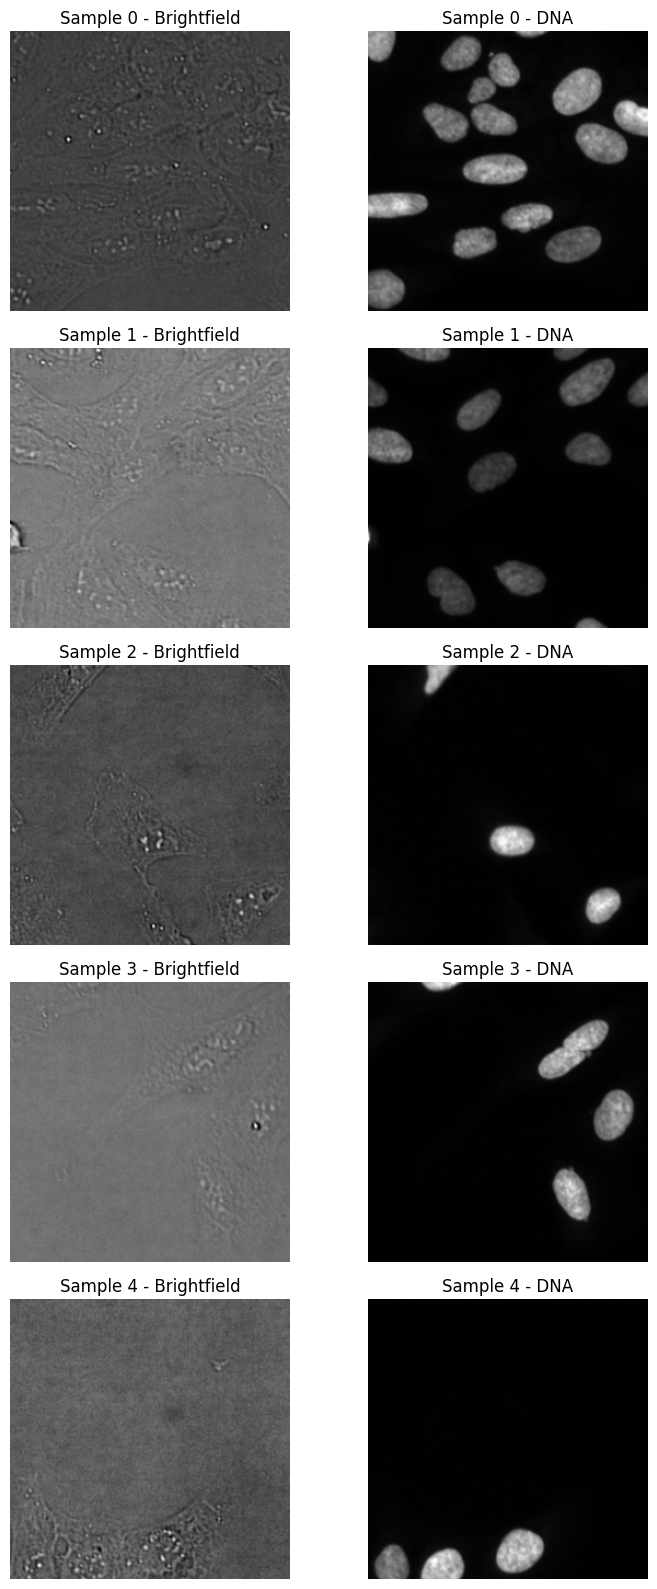

In [5]:
# Create dataset instance
dataset = SimpleDataset(X, Y, crop_size=256)
print(f"Dataset created with {len(dataset)} samples")

# Plot the first 5 samples from the dataset
fig, axes = plt.subplots(5, 2, figsize=(8, 16))

for i in range(5):
    brightfield, dna = dataset[i]
    brightfield = brightfield.numpy().squeeze()
    dna = dna.numpy().squeeze()

    # Plot brightfield image
    axes[i, 0].imshow(brightfield.squeeze(), cmap='gray')
    axes[i, 0].set_title(f'Sample {i} - Brightfield')
    axes[i, 0].axis('off')
    
    # Plot DNA image
    axes[i, 1].imshow(dna.squeeze(), cmap='gray')
    axes[i, 1].set_title(f'Sample {i} - DNA')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

## Configure and train

In [6]:
## Hyperparameters

# Batch size arbitrarily chosen for demo purposes. 
# With a value of 16, the training fits comfortably into a nvidia RTX 3090 and utilizing <10GB of VRAM.
# Tune to your hardware capabilities.
batch_size = 16 

# Small number of epochs for demo purposes
# For better training results, increase this number
epochs = 100

# larger learning rate for demo purposes,
# such that the epoch to epoch changes in model predictions are more visible
learning_rate = 0.001 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Batch with DataLoader
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model & Optimizer
fully_conv_unet = UNet(
    in_channels=1,
    out_channels=1,
    depth=4,
    encoder_down_block='conv',
    decoder_up_block='convt',
    act_type='sigmoid'
)
optimizer = torch.optim.Adam(fully_conv_unet.parameters(), lr=learning_rate)

# Plotting callback to visualize predictions during training
plot_callback = PlotPredictionCallback(
    name="plot_callback_with_train_data",
    dataset=dataset,
    indices=[0,1,2,3,4], # first 5 samples
    plot_metrics=[torch.nn.L1Loss()],
    every_n_epochs=5,
    show_plot=False
)

# MLflow Logger
logger = MlflowLogger(
    name="logger",
    experiment_name="vsf_examples",
    tracking_uri="http://127.0.0.1:5000",
    run_name="experiment_training_with_plots",
    description="Training a UNet model on a simple dataset for demo purposes",
    callbacks=[plot_callback],
    save_model_at_train_end=True,
    save_model_every_n_epochs=1,
    save_best_model=True
)

# Initialize Trainer and start training
trainer = SingleGeneratorTrainer(
    model=fully_conv_unet,
    optimizer=optimizer,
    losses=[
        torch.nn.L1Loss(),
        MultiScaleStructuralSimilarityIndexMeasure(
            data_range=1.0,
            kernel_size=11,
            sigma=1.5,
        )
    ],
    loss_weights=[1.0, -1.0], # minimize L1 distance and maximize MS-SSIM
    device=device,
    train_loader=train_loader,
    val_loader=None,
    test_loader=None,
)

trainer.train(logger=logger, epochs=epochs)

MLflow run started with ID: 92dc9e2b3a0e4e82b235343ad2cfa5fa


Training: 100%|██████████| 100/100 [05:42<00:00,  3.43s/epoch, Train Batch 4/4]


🏃 View run experiment_training_with_plots at: http://127.0.0.1:5000/#/experiments/2/runs/92dc9e2b3a0e4e82b235343ad2cfa5fa
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


## Visualize training outcome through MLflow client

### Display the last logged prediction plot artifact

Run ID: 92dc9e2b3a0e4e82b235343ad2cfa5fa
Run Name: experiment_training_with_plots
Last epoch plot: plots/epoch/plot_predictions/epoch_99.png


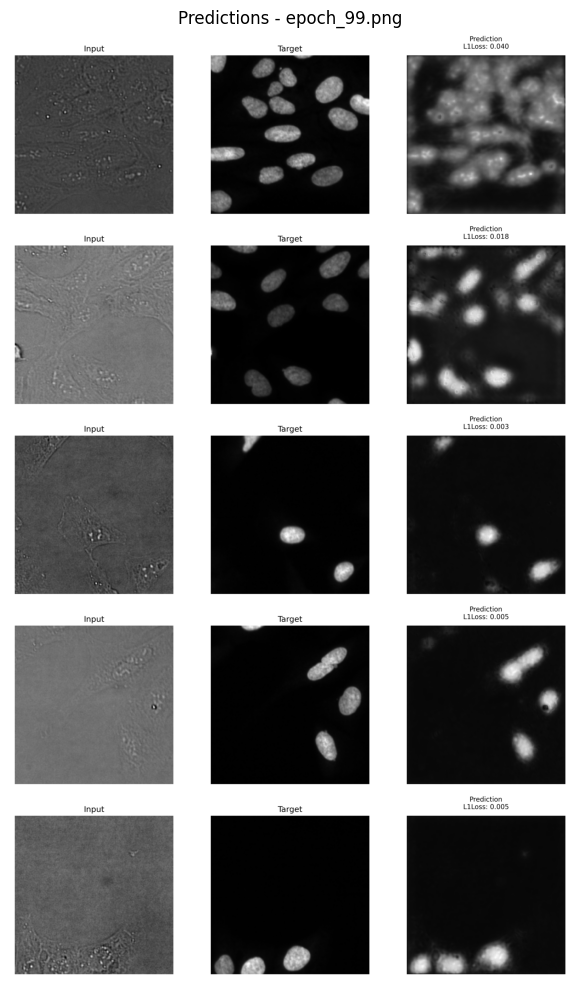

In [7]:
# Create MLflow client
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")

# Get the experiment by name
experiment = client.get_experiment_by_name("vsf_examples")

if experiment is None:
    print("Experiment 'vsf_examples' not found")
else:
    # Search for runs with the specific run name
    runs = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        filter_string="tags.mlflow.runName = 'experiment_training_with_plots'"
    )
    
    if len(runs) == 0:
        print("No runs found with name 'experiment_training_with_plots'")
    else:
        # Get the most recent run (first in list)
        run = runs[0]
        print(f"Run ID: {run.info.run_id}")
        print(f"Run Name: {run.data.tags.get('mlflow.runName')}")

        plot_artifacts = client.list_artifacts(run.info.run_id, path='plots/epoch/plot_predictions/')

        # Filter for PNG files and sort by path (which includes epoch number)
        png_files = [artifact for artifact in plot_artifacts if artifact.path.endswith('.png')]

        # Get full paths and sort by epoch number
        png_files_sorted = sorted(png_files, key=lambda x: int(x.path.split('_')[-1].split('.')[0]))
        most_recent_png = png_files_sorted[-1]

        print(f"Last epoch plot: {most_recent_png.path}")

        # Download and display the image
        local_path = client.download_artifacts(run.info.run_id, most_recent_png.path)
        img = Image.open(local_path)
        plt.figure(figsize=(12, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predictions - {most_recent_png.path.split('/')[-1]}")
        plt.tight_layout()
        plt.show()

### Also visualize metrics from tracking

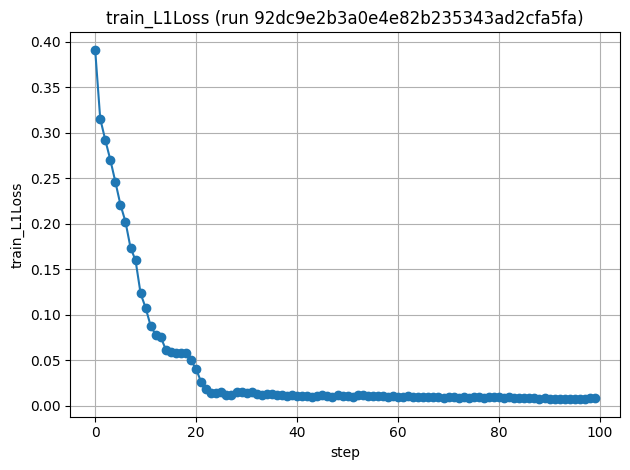

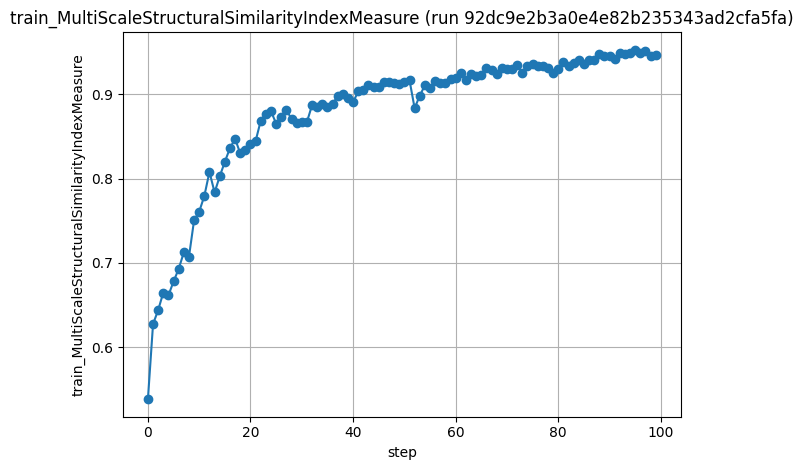

In [8]:
metric_keys = list(run.data.metrics.keys()) or []

for metric_name in metric_keys:
    # 2. Get full history for each metric (all steps)
    history = client.get_metric_history(run.info.run_id, metric_name)
    if not history:
        continue

    steps = [m.step for m in history]
    values = [m.value for m in history]

    # 3. Plot each metric vs step
    plt.figure()
    plt.plot(steps, values, marker="o")
    plt.title(f"{metric_name} (run {run.info.run_id})")
    plt.xlabel("step")
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.tight_layout()